In [1]:
# %%
# 导入基础库
import os
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 导入PyTorch相关库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, datasets
from torchvision.models import vit_b_16, ViT_B_16_Weights

# 设置随机种子，确保可复现性
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 设备设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 检查CUDA设备
if torch.cuda.is_available():
    print(f"当前CUDA设备: {torch.cuda.get_device_name(0)}")
    print(f"CUDA版本: {torch.version.cuda}")


使用设备: cuda
当前CUDA设备: NVIDIA GeForce RTX 3090
CUDA版本: 11.8


In [2]:
# %%
# 项目配置
class Config:
    # 数据集配置
    DATA_PATH = '/mnt/MCP/hagrid_classification'
    CLASSES = ['call', 'fist', 'like', 'ok', 'one', 'palm', 'rock', 'three', 'two_up']
    NUM_CLASSES = len(CLASSES)
    
    # 模型配置
    MODEL_NAME = 'ViT-B/16'  # Vision Transformer Base 16x16 patches
    INPUT_SIZE = (3, 224, 224)
    USE_PRETRAINED = True
    
    # 训练配置
    BATCH_SIZE = 32
    NUM_EPOCHS = 100
    LEARNING_RATE = 0.0001  # 通常ViT使用更小的学习率
    WEIGHT_DECAY = 0.01     # 通常ViT使用更大的权重衰减
    NUM_WORKERS = 4
    
    # 早停配置
    PATIENCE = 15
    MIN_DELTA = 0.001
    
    # 模型保存路径
    MODEL_SAVE_DIR = './models'
    BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'best_vit_gesture_model.pth')
    FINAL_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'final_vit_gesture_model.pth')

# 创建保存模型的目录
if not os.path.exists(Config.MODEL_SAVE_DIR):
    os.makedirs(Config.MODEL_SAVE_DIR)

# 检查数据集路径是否存在
if not os.path.exists(Config.DATA_PATH):
    print(f"警告: 数据路径 {Config.DATA_PATH} 不存在，请确认数据集路径！")
else:
    print(f"数据集路径已确认: {Config.DATA_PATH}")
    train_dir = os.path.join(Config.DATA_PATH, 'train')
    val_dir = os.path.join(Config.DATA_PATH, 'val')
    
    if os.path.exists(train_dir):
        print(f"训练集目录: {train_dir}")
    if os.path.exists(val_dir):
        print(f"验证集目录: {val_dir}")


数据集路径已确认: /mnt/MCP/hagrid_classification
训练集目录: /mnt/MCP/hagrid_classification/train
验证集目录: /mnt/MCP/hagrid_classification/val


训练集大小: 204187
验证集大小: 26990
类别映射: {'call': 0, 'fist': 1, 'like': 2, 'ok': 3, 'one': 4, 'palm': 5, 'rock': 6, 'three': 7, 'two_up': 8}


/tmp/ipykernel_16061/377457279.py:128: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_16061/377457279.py:128: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from current font.
  plt.tight_layout()
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


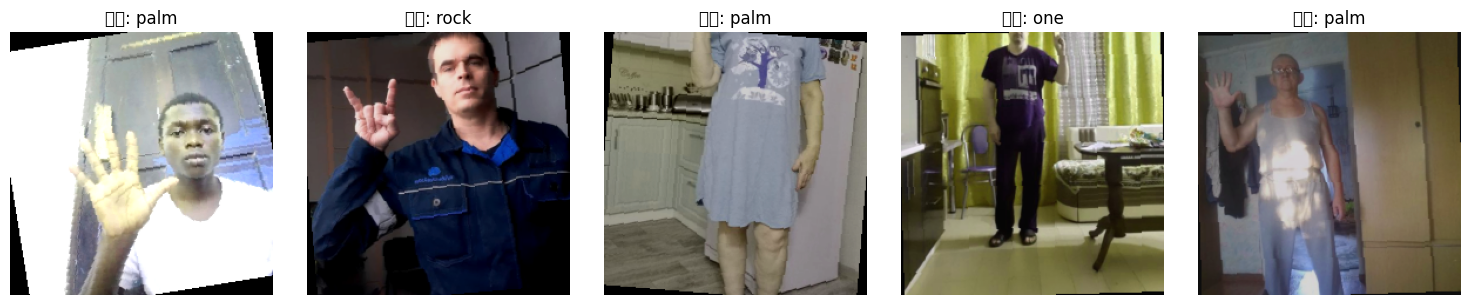

In [3]:
# %%
# 定义数据增强和转换
def get_data_transforms():
    """
    创建训练和验证数据集的转换流水线
    注意：ViT通常需要特定的前处理
    
    返回:
        train_transforms, val_transforms: 两个转换对象
    """
    # ViT预训练模型推荐的预处理
    # 使用ImageNet的均值和标准差
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    # 训练数据增强
    train_transforms = transforms.Compose([
        transforms.Resize(256),              # 调整大小为256x256
        transforms.RandomCrop(224),          # 随机裁剪到224x224
        transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
        transforms.RandomRotation(10),       # 小角度旋转
        transforms.ColorJitter(              # 颜色变换
            brightness=0.2,                  
            contrast=0.2,                    
            saturation=0.2,                  
            hue=0.1                          
        ),
        transforms.ToTensor(),               # 转换为Tensor
        transforms.Normalize(mean=mean, std=std)  # 标准化
    ])
    
    # 验证数据转换
    val_transforms = transforms.Compose([
        transforms.Resize(256),              # 调整大小
        transforms.CenterCrop(224),          # 中心裁剪，保持一致
        transforms.ToTensor(),               # 转换为Tensor
        transforms.Normalize(mean=mean, std=std)  # 标准化
    ])
    
    return train_transforms, val_transforms

# 加载并预处理数据集
def load_datasets():
    """
    加载并预处理训练集和验证集
    
    返回:
        train_dataset, val_dataset: 两个数据集对象
    """
    # 获取数据转换
    train_transforms, val_transforms = get_data_transforms()
    
    # 加载数据集
    train_dataset = datasets.ImageFolder(
        root=os.path.join(Config.DATA_PATH, 'train'),
        transform=train_transforms
    )
    
    val_dataset = datasets.ImageFolder(
        root=os.path.join(Config.DATA_PATH, 'val'),
        transform=val_transforms
    )
    
    # 输出数据集信息
    print(f"训练集大小: {len(train_dataset)}")
    print(f"验证集大小: {len(val_dataset)}")
    print(f"类别映射: {train_dataset.class_to_idx}")
    
    return train_dataset, val_dataset

# 创建数据加载器
def create_data_loaders(train_dataset, val_dataset):
    """
    为训练集和验证集创建数据加载器
    
    参数:
        train_dataset: 训练数据集
        val_dataset: 验证数据集
    返回:
        train_loader, val_loader: 两个数据加载器
    """
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True
    )
    
    return train_loader, val_loader

# 执行数据加载
train_dataset, val_dataset = load_datasets()
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset)

# 可视化一些训练样本
def visualize_samples(dataset, num_samples=5):
    """可视化数据集的样本"""
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    # 反标准化函数
    def denormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return torch.clamp(tensor * std + mean, 0, 1)
    
    for i in range(num_samples):
        # 随机选择样本
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        
        # 反标准化图像
        img = denormalize(img)
        
        # 显示图像
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(f"类别: {Config.CLASSES[label]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# 可视化一些样本
visualize_samples(train_dataset)


In [4]:
# %%
# 定义基于ViT的手势识别模型
class GestureViT(nn.Module):
    """
    基于Vision Transformer的手势识别模型
    """
    
    def __init__(self, num_classes=9, use_pretrained=True):
        """
        初始化ViT模型
        
        参数:
            num_classes (int): 类别数量
            use_pretrained (bool): 是否使用预训练权重
        """
        super(GestureViT, self).__init__()
        
        # 加载预训练的ViT模型
        if use_pretrained:
            # 使用预训练权重
            weights = ViT_B_16_Weights.IMAGENET1K_V1
            self.vit_model = vit_b_16(weights=weights)
            print("加载预训练的ViT-B/16模型（ImageNet权重）")
        else:
            self.vit_model = vit_b_16(weights=None)
            print("初始化ViT-B/16模型（无预训练权重）")
        
        # 修改分类头以匹配我们的类别数
        # ViT的分类头是最后的线性层
        num_features = self.vit_model.heads.head.in_features
        self.vit_model.heads.head = nn.Linear(num_features, num_classes)
        
        # 添加一个Dropout层防止过拟合
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        """前向传播"""
        x = self.vit_model(x)
        x = self.dropout(x)
        return x

# 初始化模型
def initialize_model():
    """
    初始化并配置手势识别ViT模型
    
    返回:
        model: 配置好的模型
    """
    # 创建模型
    model = GestureViT(
        num_classes=Config.NUM_CLASSES,
        use_pretrained=Config.USE_PRETRAINED
    )
    
    # 将模型移到指定设备
    model = model.to(device)
    
    # 统计模型参数
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"总参数量: {total_params:,}")
    print(f"可训练参数量: {trainable_params:,}")
    
    return model

# 初始化模型
model = initialize_model()

# 打印模型架构简要信息
print(model)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:47<00:00, 7.35MB/s] 


加载预训练的ViT-B/16模型（ImageNet权重）
总参数量: 85,805,577
可训练参数量: 85,805,577
GestureViT(
  (vit_model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
    

In [5]:
# %%
# 定义损失函数和优化器
def configure_training(model):
    """
    配置训练所需的损失函数、优化器和学习率调度器
    ViT通常需要特定的训练配置
    
    参数:
        model: 要训练的模型
    返回:
        criterion, optimizer, scheduler: 损失函数、优化器和学习率调度器
    """
    # 损失函数：交叉熵损失（适用于多分类问题）
    criterion = nn.CrossEntropyLoss()
    
    # 优化器：AdamW优化器，通常用于Transformer模型
    optimizer = optim.AdamW(
        model.parameters(),
        lr=Config.LEARNING_RATE,
        weight_decay=Config.WEIGHT_DECAY
    )
    
    # 学习率调度器：余弦退火，随着训练的进行逐渐降低学习率
    scheduler = CosineAnnealingLR(
        optimizer,
        T_max=Config.NUM_EPOCHS
    )
    
    return criterion, optimizer, scheduler

# 配置训练组件
criterion, optimizer, scheduler = configure_training(model)

# 定义早停机制
class EarlyStopping:
    """早停机制，防止过拟合"""
    
    def __init__(self, patience=15, min_delta=0.001):
        """
        初始化早停对象
        
        参数:
            patience (int): 容忍的epoch数
            min_delta (float): 最小改善阈值
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        """
        调用以更新早停状态
        
        参数:
            val_loss (float): 当前验证损失
        """
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# 初始化早停机制
early_stopping = EarlyStopping(
    patience=Config.PATIENCE,
    min_delta=Config.MIN_DELTA
)


In [6]:
# %%
# 训练和验证函数
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    训练模型一个epoch
    
    参数:
        model: 模型
        dataloader: 训练数据加载器
        criterion: 损失函数
        optimizer: 优化器
        device: 计算设备
    
    返回:
        epoch_loss, epoch_acc: 该epoch的平均损失和准确率
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 使用tqdm显示进度条
    pbar = tqdm(dataloader, desc="训练中")
    
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播
        loss.backward()
        
        # 参数更新
        optimizer.step()
        
        # 累计损失
        running_loss += loss.item() * inputs.size(0)
        
        # 计算准确率
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 更新进度条
        pbar.set_postfix({
            'loss': loss.item(),
            'acc': correct / total
        })
    
    # 计算整个epoch的平均损失和准确率
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """
    验证模型性能
    
    参数:
        model: 模型
        dataloader: 验证数据加载器
        criterion: 损失函数
        device: 计算设备
    
    返回:
        val_loss, val_acc, all_preds, all_labels: 验证损失、准确率和预测结果
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="验证中"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # 累计损失
            running_loss += loss.item() * inputs.size(0)
            
            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # 保存预测结果和标签，用于后续计算指标
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 计算整体验证损失和准确率
    val_loss = running_loss / len(dataloader.dataset)
    val_acc = correct / total
    
    return val_loss, val_acc, all_preds, all_labels


In [8]:
# %%
# 训练循环
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    history = {
        'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [],
        'best_epoch': 0, 'best_val_acc': 0.0
    }
    start_time = time.time()
    best_val_acc = 0.0
    
    # 引入tqdm进度条（可选，需安装：pip install tqdm）
    from tqdm import tqdm
    epoch_range = tqdm(range(num_epochs), desc="训练进度")  # 总进度条
    
    for epoch in epoch_range:
        epoch_start_time = time.time()
        
        # 训练一个epoch（确保train_one_epoch内部无batch打印）
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        
        # 验证（确保validate内部无batch打印）
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
        
        scheduler.step()
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # 合并epoch信息为1行（通过tqdm的进度条描述展示，减少print）
        epoch_time = time.time() - epoch_start_time
        lr = optimizer.param_groups[0]['lr']
        epoch_range.set_postfix_str(
            f"Epoch {epoch+1}/{num_epochs} | "
            f"训练损失: {train_loss:.4f}, 准确率: {train_acc:.4f} | "
            f"验证损失: {val_loss:.4f}, 准确率: {val_acc:.4f} | "
            f"学习率: {lr:.6f}, 用时: {epoch_time:.2f}秒"
        )
        
        # 简化模型保存提示
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            history['best_val_acc'] = best_val_acc
            history['best_epoch'] = epoch + 1
            torch.save(model.state_dict(), Config.BEST_MODEL_PATH)
            # 仅在控制台打印一次关键信息（而非每个epoch多次）
            print(f"\n[更新] 最佳模型已保存（准确率: {best_val_acc:.4f}，Epoch {epoch+1}）")
        
        # 早停提示简化
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"\n早停触发，停止于Epoch {epoch+1}")
            break
    
    # 训练结束信息保持简洁
    total_time = time.time() - start_time
    hours, remainder = divmod(total_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"\n训练完成！总用时: {int(hours)}h {int(minutes)}m {int(seconds)}s")
    print(f"最佳验证准确率: {best_val_acc:.4f}（Epoch {history['best_epoch']}）")
    torch.save(model.state_dict(), Config.FINAL_MODEL_PATH)
    print(f"最终模型已保存至: {Config.FINAL_MODEL_PATH}")
    
    return history

# 执行训练
training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=Config.NUM_EPOCHS
)

# 可视化训练历史
def plot_training_history(history):
    """绘制训练和验证的损失和准确率曲线"""
    plt.figure(figsize=(12, 5))
    
    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='训练损失')
    plt.plot(history['val_loss'], label='验证损失')
    plt.xlabel('Epoch')
    plt.ylabel('损失')
    plt.title('训练和验证损失')
    plt.legend()
    plt.grid(True)
    
    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='训练准确率')
    plt.plot(history['val_acc'], label='验证准确率')
    plt.xlabel('Epoch')
    plt.ylabel('准确率')
    plt.title('训练和验证准确率')
    plt.legend()
    plt.grid(True)
    
    # 标记最佳epoch
    best_epoch = history['best_epoch'] - 1
    plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# 可视化训练历史
plot_training_history(training_history)


训练进度:   0%|          | 0/100 [00:00<?, ?it/s]

训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:   1%|          | 1/100 [27:30<45:23:29, 1650.60s/it, Epoch 1/100 | 训练损失: 0.3725, 准确率: 0.8567 | 验证损失: 0.1681, 准确率: 0.9423 | 学习率: 0.000099, 用时: 1649.63秒]


[更新] 最佳模型已保存（准确率: 0.9423，Epoch 1）


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:   2%|▏         | 2/100 [54:59<44:53:55, 1649.34s/it, Epoch 2/100 | 训练损失: 0.3620, 准确率: 0.8600 | 验证损失: 0.1496, 准确率: 0.9472 | 学习率: 0.000099, 用时: 1647.71秒]


[更新] 最佳模型已保存（准确率: 0.9472，Epoch 2）


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:   3%|▎         | 3/100 [1:22:31<44:28:51, 1650.84s/it, Epoch 3/100 | 训练损失: 0.3492, 准确率: 0.8642 | 验证损失: 0.1421, 准确率: 0.9497 | 学习率: 0.000099, 用时: 1651.86秒]


[更新] 最佳模型已保存（准确率: 0.9497，Epoch 3）


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve


[更新] 最佳模型已保存（准确率: 0.9519，Epoch 6）


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  13%|█▎        | 13/100 [5:57:25<39:50:50, 1648.86s/it, Epoch 13/100 | 训练损失: 0.2888, 准确率: 0.8848 | 验证损失: 0.1221, 准确率: 0.9577 | 学习率: 0.000093, 用时: 1645.88秒]


[更新] 最佳模型已保存（准确率: 0.9577，Epoch 13）


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  16%|█▌        | 16/100 [7:19:54<38:29:15, 1649.47s/it, Epoch 16/100 | 训练损失: 0.2767, 准确率: 0.8886 | 验证损失: 0.1096, 准确率: 0.9613 | 学习率: 0.000090, 用时: 1649.16秒]


[更新] 最佳模型已保存（准确率: 0.9613，Epoch 16）


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  23%|██▎       | 23/100 [10:32:24<35:17:59, 1650.39s/it, Epoch 23/100 | 训练损失: 0.2583, 准确率: 0.8942 | 验证损失: 0.1005, 准确率: 0.9663 | 学习率: 0.000083, 用时: 1650.95秒]


[更新] 最佳模型已保存（准确率: 0.9663，Epoch 23）


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  26%|██▌       | 26/100 [11:54:51<33:54:04, 1649.25s/it, Epoch 26/100 | 训练损失: 0.2477, 准确率: 0.8981 | 验证损失: 0.1051, 准确率: 0.9649 | 学习率: 0.000079, 用时: 1647.16秒]

训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  30%|███       | 30/100 [13:44:48<32:03:59, 1649.13s/it, Epoch 30/100 | 训练损失: 0.2363, 准确率: 0.9020 | 验证损失: 0.1022, 准确率: 0.9658 | 学习率: 0.000074, 用时: 1649.57秒]

训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  31%|███       | 31/100 [14:12:13<31:35:09, 1647.96s/it, Epoch 31/100 | 训练损失: 0.2363, 准确率: 0.9025 | 验证损失: 0.1002, 准确率: 0.9669 | 学习率: 0.000073, 用时: 1645.21秒]

训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  32%|███▏      | 32/100 [14:39:44<31:08:35, 1648.76s/it, Epoch 32/100 | 训练损失: 0.2341, 准确率: 0.9021 | 验证损失: 0.1012, 准确率: 0.9677 | 学习率: 0.000071, 用时: 1650.63秒]

训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  33%|███▎      | 33/100 [15:07:12<30:41:05, 1648.74s/it, Epoch 33/100 | 训练损失: 0.2300, 准确率: 0.9040 | 验证损失: 0.1005, 准确率: 0.9664 | 学习率: 0.000070, 用时: 1648.68秒]

训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  34%|███▍      | 34/100 [15:34:42<30:14:02, 1649.13s/it, Epoch 34/100 | 训练损失: 0.2279, 准确率: 0.9047 | 验证损失: 0.0963, 准确率: 0.9678 | 学习率: 0.000068, 用时: 1650.06秒]

训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  35%|███▌      | 35/100 [16:02:13<29:46:54, 1649.45s/it, Epoch 35/100 | 训练损失: 0.2254, 准确率: 0.9051 | 验证损失: 0.0969, 准确率: 0.9682 | 学习率: 0.000067, 用时: 1650.19秒]

训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  36%|███▌      | 36/100 [16:29:42<29:19:23, 1649.42s/it, Epoch 36/100 | 训练损失: 0.2226, 准确率: 0.9062 | 验证损失: 0.0963, 准确率: 0.9691 | 学习率: 0.000065, 用时: 1648.61秒]


[更新] 最佳模型已保存（准确率: 0.9691，Epoch 36）


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

训练进度:  37%|███▋      | 37/100 [16:57:12<28:52:12, 1649.72s/it, Epoch 37/100 | 训练损失: 0.2235, 准确率: 0.9058 | 验证损失: 0.0937, 准确率: 0.9690 | 学习率: 0.000064, 用时: 1650.39秒]

训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve


[更新] 最佳模型已保存（准确率: 0.9706，Epoch 40）


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  43%|████▎     | 43/100 [19:42:09<26:07:18, 1649.80s/it, Epoch 43/100 | 训练损失: 0.2085, 准确率: 0.9113 | 验证损失: 0.0873, 准确率: 0.9710 | 学习率: 0.000055, 用时: 1649.00秒]

训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  50%|█████     | 50/100 [22:54:43<22:55:24, 1650.49s/it, Epoch 50/100 | 训练损失: 0.1938, 准确率: 0.9166 | 验证损失: 0.0878, 准确率: 0.9733 | 学习率: 0.000044, 用时: 1649.46秒]


[更新] 最佳模型已保存（准确率: 0.9733，Epoch 50）


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  51%|█████     | 51/100 [23:22:13<22:27:58, 1650.57s/it, Epoch 51/100 | 训练损失: 0.1930, 准确率: 0.9163 | 验证损失: 0.0902, 准确率: 0.9720 | 学习率: 0.000042, 用时: 1650.76秒]

训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  52%|█████▏    | 52/100 [23:49:43<22:00:18, 1650.38s/it, Epoch 52/100 | 训练损失: 0.1905, 准确率: 0.9174 | 验证损失: 0.0924, 准确率: 0.9718 | 学习率: 0.000041, 用时: 1649.91秒]

训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  53%|█████▎    | 53/100 [24:17:11<21:32:12, 1649.63s/it, Epoch 53/100 | 训练损失: 0.1887, 准确率: 0.9179 | 验证损失: 0.0874, 准确率: 0.9743 | 学习率: 0.000039, 用时: 1647.15秒]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rat

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  56%|█████▌    | 56/100 [25:39:39<20:09:30, 1649.33s/it, Epoch 56/100 | 训练损失: 0.1843, 准确率: 0.9198 | 验证损失: 0.0924, 准确率: 0.9739 | 学习率: 0.000035, 用时: 1649.18秒]

训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve


[更新] 最佳模型已保存（准确率: 0.9756，Epoch 59）


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

训练进度:  60%|██████    | 60/100 [27:29:38<18:19:

训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

训练进度:  63%|██████▎   | 63/100 [28:52:07<16:57:

训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  66%|██████▌   | 66/100 [30:14:36<15:34:44, 1649.53s/it, Epoch 66/100 | 训练损失: 0.1670, 准确率: 0.9248 | 验证损失: 0.0898, 准确率: 0.9765 | 学习率: 0.000021, 用时: 1648.14秒]


[更新] 最佳模型已保存（准确率: 0.9765，Epoch 66）


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

训练进度:  70%|███████   | 70/100 [32:04:30<13:44:17, 1648.58s/it, Epoch 70/100 | 训练损失: 0.1647, 准确率: 0.9261 | 验证损失: 0.0905, 准确率: 0.9766 | 学习率: 0.000016, 用时: 1648.92秒]

训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

开始模型评估...


验证中:   0%|          | 0/844 [00:00<?, ?it/s]


===== 模型评估结果 =====
准确率 (Accuracy): 0.9773
精确率 (Precision): 0.9774
召回率 (Recall): 0.9773
F1值 (F1 Score): 0.9773

各类别指标:
       类别       精确率       召回率       F1值
0    call  0.984707  0.987333  0.986019
1    fist  0.982903  0.977659  0.980274
2    like  0.982678  0.983661  0.983169
3      ok  0.984985  0.984328  0.984656
4     one  0.950874  0.961333  0.956075
5    palm  0.991946  0.985662  0.988794
6    rock  0.968386  0.970971  0.969677
7   three  0.983778  0.970981  0.977338
8  two_up  0.965928  0.973658  0.969777


/tmp/ipykernel_16061/4085821903.py:90: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_16061/4085821903.py:90: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_16061/4085821903.py:90: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_16061/4085821903.py:90: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_16061/4085821903.py:90: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_16061/4085821903.py:90: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_16061/4085821903.py:90: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from current font.
  plt.

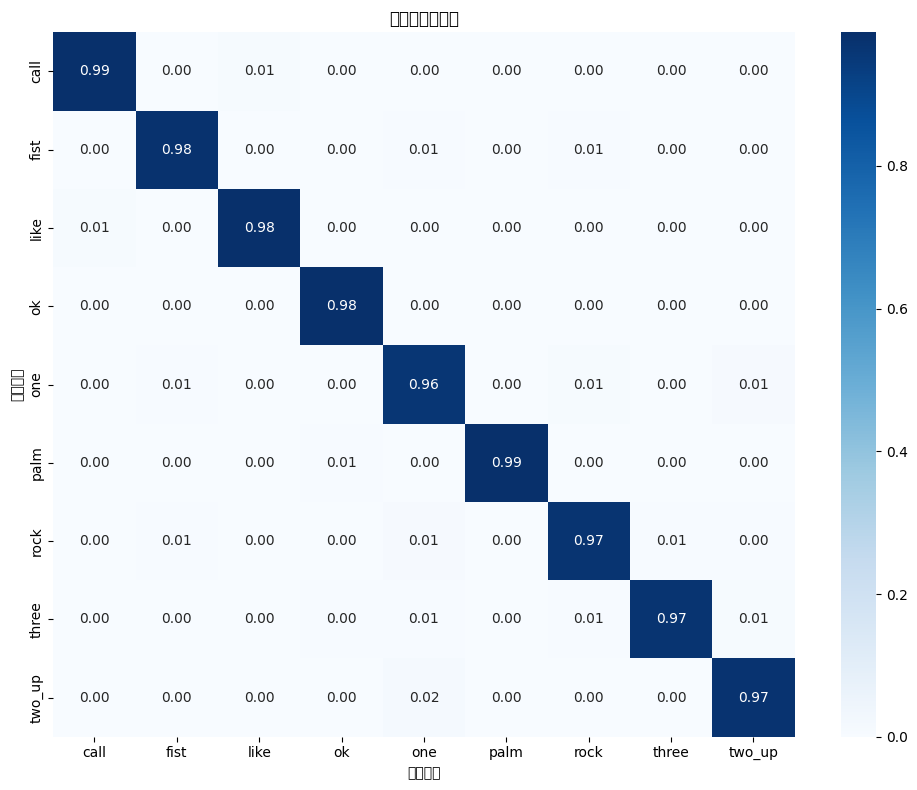

/tmp/ipykernel_16061/4085821903.py:113: UserWarning: Glyph 25163 (\N{CJK UNIFIED IDEOGRAPH-624B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_16061/4085821903.py:113: UserWarning: Glyph 21183 (\N{CJK UNIFIED IDEOGRAPH-52BF}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_16061/4085821903.py:113: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_16061/4085821903.py:113: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_16061/4085821903.py:113: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_16061/4085821903.py:113: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_16061/4085821903.py:113: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from current font.

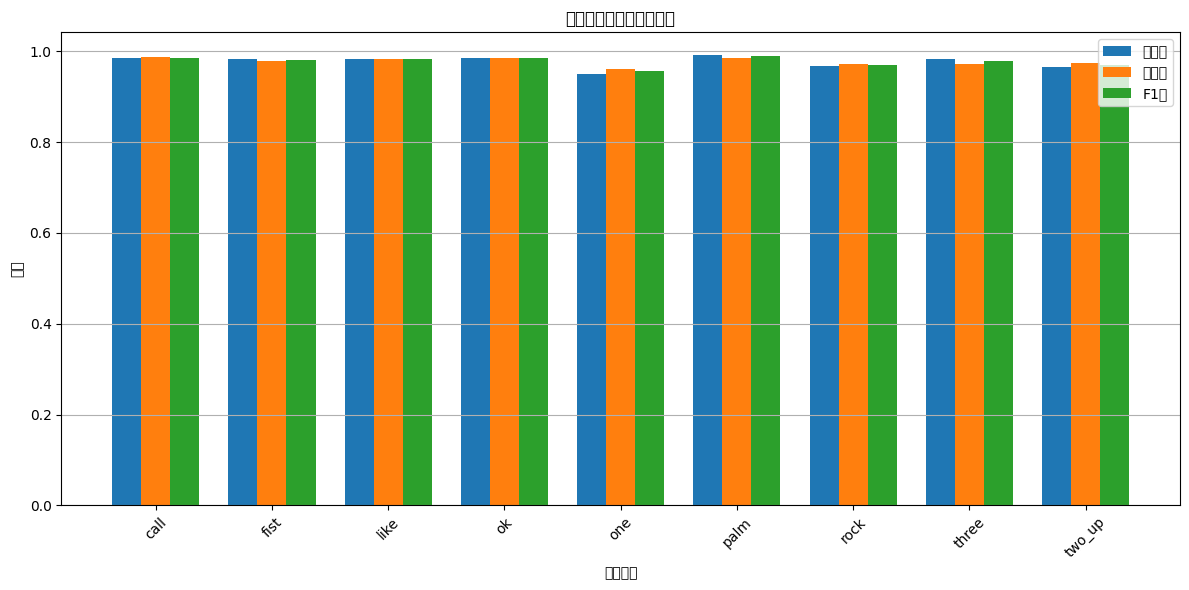

In [9]:
# %%
# 模型评估
def evaluate_model(model, dataloader, criterion, device):
    """
    全面评估模型性能
    
    参数:
        model: 要评估的模型
        dataloader: 数据加载器
        criterion: 损失函数
        device: 计算设备
    
    返回:
        评估指标和预测结果
    """
    print("开始模型评估...")
    
    # 加载最佳模型
    model.load_state_dict(torch.load(Config.BEST_MODEL_PATH))
    model.eval()
    
    # 获取验证集上的损失、准确率和预测
    val_loss, val_acc, all_preds, all_labels = validate(model, dataloader, criterion, device)
    
    # 计算评估指标
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # 输出评估结果
    print("\n===== 模型评估结果 =====")
    print(f"准确率 (Accuracy): {accuracy:.4f}")
    print(f"精确率 (Precision): {precision:.4f}")
    print(f"召回率 (Recall): {recall:.4f}")
    print(f"F1值 (F1 Score): {f1:.4f}")
    
    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    
    # 每个类别的精确率、召回率和F1值
    print("\n各类别指标:")
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    
    class_metrics = pd.DataFrame({
        '类别': Config.CLASSES,
        '精确率': precision_per_class,
        '召回率': recall_per_class,
        'F1值': f1_per_class
    })
    
    print(class_metrics)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'true_labels': all_labels,
        'class_metrics': class_metrics
    }

# 执行评估
eval_results = evaluate_model(model, val_loader, criterion, device)

# 绘制混淆矩阵
def plot_confusion_matrix(cm, class_names):
    """绘制混淆矩阵热图"""
    plt.figure(figsize=(10, 8))
    
    # 归一化混淆矩阵
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(
        cm_norm, 
        annot=True, 
        fmt='.2f', 
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    
    plt.title('归一化混淆矩阵')
    plt.ylabel('真实类别')
    plt.xlabel('预测类别')
    plt.tight_layout()
    plt.show()

# 绘制混淆矩阵
plot_confusion_matrix(eval_results['confusion_matrix'], Config.CLASSES)

# 绘制各类别性能比较
def plot_class_metrics(class_metrics):
    """绘制各类别的性能指标"""
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(Config.CLASSES))
    width = 0.25
    
    plt.bar(x - width, class_metrics['精确率'], width, label='精确率')
    plt.bar(x, class_metrics['召回率'], width, label='召回率')
    plt.bar(x + width, class_metrics['F1值'], width, label='F1值')
    
    plt.xlabel('手势类别')
    plt.ylabel('分数')
    plt.title('各手势类别性能指标比较')
    plt.xticks(x, Config.CLASSES, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(True, axis='y')
    plt.show()

# 绘制各类别性能比较
plot_class_metrics(eval_results['class_metrics'])
